# Tarea 0
# INF477 Redes Neuronales Artificiales I-2018

Profesor: Dr. Ricardo Ñanculef -- 
Ayudante: Francisco Mena

Alumna: Eliana Providel Godoy, eprovide@inf.utfsm.cl

# 1) Back-propagation from Scratch

## a)  Entrenar red FF

### i) Forward Pass

In [1]:
import numpy as np

# Declaración de pesos

## W_1 (4x32) --  de las 4 entradas a las 32 neuronas de la capa oculta 1
## Se inicializa con valores aleatorios entre [0,1[
W_1 = np.asmatrix(np.random.random_sample((4,32)), dtype=np.float64) 

## W_2 (32x16) -- de las 32 neuronas de la capa oculta 1 a las 16 neuronas de la capa oculta 2
## Se inicializa con valores aleatorios entre [0,1[
W_2 = np.asmatrix(np.random.random_sample((32,16)), dtype=np.float64) 

## W_out (16x3) -- de las 16 neuronas de la capa oculta 2 a las 3 neuronas de la capa de salida
## Se inicializa con valores aleatorios entre [0,1[
W_out = np.asmatrix(np.random.random_sample((16,3)), dtype=np.float64) 


##Por simplicidad no se considero el uso de sesgos.


Funciones de activación

In [2]:
def relu(M):
    return np.maximum(0,M)

def softmax(z):
    e_z = np.exp(z-np.max(z))
    return e_z / e_z.sum(axis = 0)    
    

Implementación de forward pass

In [3]:
def forwardpass(x_in, W_1, W_2, W_out, actfunc):
    ## Los resultados de la pre activación se almacenaran en a_k y los resultados de la activación en h_k
    
    #De  la entrada a la capa 1
    a_1 = W_1.T * x_in
    h_1 = actfunc(a_1)
    
    #De  la capa 1 a la capa 2
    a_2 = W_2.T * h_1
    h_2 = actfunc(a_2)
    
    #De  la capa 2 a la salida
    a_out = W_out.T * h_2
    h_out = softmax(a_out)
    
    return h_out, [(a_out, a_2, a_1),(h_out, h_2, h_1)]

### ii) Implementación de backward pass

In [4]:
def backwardpass(x_in, predicted, expected, lossfunc, 
                 d_out, d_2, d_1,  ## derivadas de la activación de cada capa
                 a_out, a_2, a_1,  ## valores de preactivación
                 h_out, h_2, h_1,  ## valores de activación
                 W_out, W_2, W_1): ## pesos
    
    ## Error entre el valor predecido y esperado
    error = lossfunc(expected, predicted)
    
    ## Primer elemento del gradiente en la capa de salida
    dZ = np.multiply(error, d_out(predicted))
    
    ## Calcula el delta de los pesos
    delta_W_out = h_2.dot(dZ.T)
    
    ## segunda elemento del gradiente en la capa oculta 2
    dH_2 = np.multiply(W_out*dZ,d_2(h_2))
    
    ## Calcula el delta de los pesos
    delta_W_2 = h_1.dot(dH_2.T)
    
    ## tercer elemento del gradiente en la capa oculta 1
    dH_1 = np.multiply(W_2*dH_2,d_1(h_1))
    
    ## Calcula el delta de los pesos
    delta_W_1 = x_in.dot(dH_1.T)
    
    return (delta_W_out, delta_W_2, delta_W_1)

### iii) Función para entrenar

In [5]:
## función que entrega la derivada de softmax
## Solo funciona para un vector de 3x1
def d_softmax(y):
    y0 = y[0,0]
    y[0,0] = y0 * (1-y0)
    y[1,0] = -(y0 * y[1,0])
    y[2,0] = -(y0 * y[2,0])

    return y

In [6]:
import random

In [7]:
def train(examples,expecteds, ## Ejemplos de entrenamiento y valores esperados
          W_1, W_2, W_out,    ## Pesos iniciales del entrenamiento
          actfunc, d_actfunc, ## Función de activación y su derivada
          lossfunc, num_epochs): ## Función de costo y número de epoch
    
    ##Tasa de aprendizaje
    LR = 0.1 
    ## Cantidad de ejemplos, considera el numero de filas del la matriz de entrada ejemplos
    nt = examples.shape[0] 
    
    ## Almacena el costo en cada epoch para ser usado en los gráficos
    loss_list = []
    
    for epoch in range(num_epochs):
        
        i = random.randint(0,nt-1)
        x_example = np.asmatrix(examples[i]).T
        y_expected = expecteds[i]
        
        ## Se ejecuta el forward pass para el ejemplo seleccionado aleatoriamente.  Retorna el valor predecido
        ## y los valores de preactivación y activación
        y_predicted, (a_s, h_s)= forwardpass(x_example, W_1, W_2, W_out, actfunc)
        
        loss_list.append(lossfunc(y_expected, y_predicted))
        
        ## Ejecuta el backward pass para obtener los ajustes de los pesos
        delta_W_out, delta_W_2, delta_W_1 = backwardpass(x_example, y_predicted, y_expected, lossfunc, 
                 d_softmax, d_actfunc, d_actfunc,  
                 a_s[0], a_s[1], a_s[2],  
                 h_s[0], h_s[1], h_s[2],  
                 W_out, W_2, W_1)
        
        ##Ajustar los pesos
        W_1 = W_1 - LR*delta_W_1
        W_2 = W_2 - LR*delta_W_2
        W_out = W_out - LR*delta_W_out
        
    return W_out, W_2, W_1, range(num_epochs),loss_list

## b) Predicciones mediante FF

### Función de decisión

In [8]:
## retorna el indice del valor máximo del vector (3x1)
## esto corresponde a la clase predecida, ya que se sabe que la salida fue calculada con softmax
## y por tanto los valores representan la probabilidad de que el elemento perteneza a la clase
## por lo tanto retornar el índice del máximo significa decir a cuál clase es mas probable que 
## percenezca el valor que genero y
def decision(y):
    return y.tolist().index(max(y))  ## se transforma en lista para utiizar el método index

def decision_vec(Y):
    return  np.apply_along_axis(lambda x:decision(np.asarray(x)),1,Y)

### Forward pass vectorial 

In [9]:
def forwardpass_vec(X, W_1, W_2, W_out, actfunc):
    #De  la entrada a la capa 1
    A_1 = X*W_1
    H_1 = actfunc(A_1)
    
    #De  la capa 1 a la capa 2
    A_2 = H_1*W_2
    H_2 = actfunc(A_2)
    
    #De  la capa 2 a la salida
    A_out = H_2*W_out
    ## Cada fila de A_out es el resultado de un ejemplo específico, entonces a cada fila 
    ## se aplica softmax de manera independiente, para que cada resultado asocie las probabilidades 
    ## correctas de pertenecer a las clases
    # segundo parametro indica que es por fila o columna, para filas = 1
    H_out = np.apply_along_axis(lambda x:softmax(np.asarray(x)[0]),1,A_out)
    
    return H_out

## c) Clasificación con dataset Iris

In [10]:

from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_iris
X_train,y_train = load_iris(return_X_y=True)
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
#transform target to one hot vector
import keras
y_onehot = keras.utils.to_categorical(y_train)

Using TensorFlow backend.


### Usando la función de entrenamiento

* Caso 1: Función de costo/perdida = MSE y activación = RELU
* Caso 2: Función de costo/perdida = MSE y activación = Sigmoid
* Caso 3: Función de costo/perdida = cross entropy y activación = RELU
* Caso 4: Función de costo/perdida = cross entropy y activación = Sigmoid    

In [11]:
from keras.losses import categorical_crossentropy

## Declaración de funciones
def loss_mse(expected, predicted):
    return np.square(expected-predicted).mean()

def cross_entropy(expected, predicted):     
    return loss_mse(expected, predicted)
    
#    m = X.shape[0]
#    print("CE m: %s" % m)
#    cost = -(1.0/m) * np.sum(y*np.log(X) + (1-y)*np.log(1-X))
#    return cost

def d_relu_z(z):
    if z > 0:
        return 1
    else:
        return 0
    
def d_relu(M):
    return np.vectorize(d_relu_z)(M)

def sigmoid(z):
    return (1 / (1 + np.exp(-z)))

def d_sigmoid_z(z):
    return (z * (1.0-z))

def d_sigmoid(M):
    return np.vectorize(d_sigmoid_z)(M)

In [12]:
## Entrenar
import time
import matplotlib.pyplot as plt
%matplotlib inline

Caso 1:

Tiempo  Entrenamiento caso 1: 0.2264692783355713 (seg) 


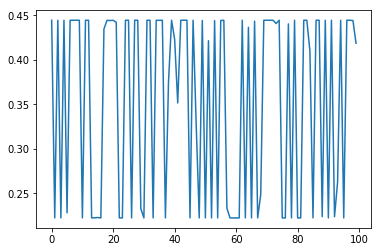

In [13]:
C1_start = time.time()
C1_W_out, C1_W_2, C1_W_1, C1_epochs, C1_losses = train(X_train,y_onehot, ## Ejemplos de entrenamiento y valores esperados
                                 W_1, W_2, W_out,    ## Pesos iniciales del entrenamiento
                                 relu, d_relu, ## Función de activación y su derivada
                                 loss_mse, 100)
C1_end = time.time()
C1_time = C1_end - C1_start
print ("Tiempo  Entrenamiento caso 1: %s (seg) " % C1_time)
plt.plot(C1_epochs,C1_losses)

Caso 2: 

Tiempo  Entrenamiento caso 2: 0.052503108978271484 (seg) 


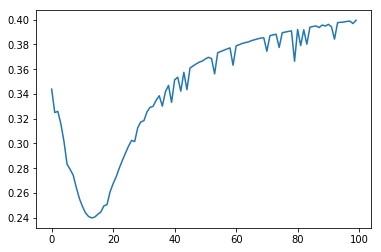

In [14]:
C2_start = time.time()
C2_W_out, C2_W_2, C2_W_1, C2_epochs, C2_losses = train(X_train,y_onehot, ## Ejemplos de entrenamiento y valores esperados
                                 W_1, W_2, W_out,    ## Pesos iniciales del entrenamiento
                                 sigmoid, d_sigmoid, ## Función de activación y su derivada
                                 loss_mse, 100)
C2_end = time.time()
C2_time = C2_end - C2_start
print ("Tiempo  Entrenamiento caso 2: %s (seg) " % C2_time)
plt.plot(C2_epochs,C2_losses)

Caso 3:

Tiempo  Entrenamiento caso 3: 0.052773237228393555 (seg) 


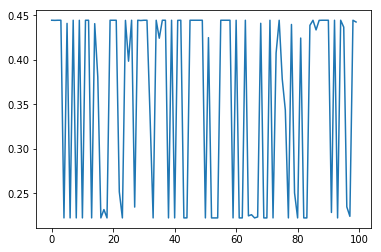

In [15]:
C3_start = time.time()
C3_W_out, C3_W_2, C3_W_1, C3_epochs, C3_losses = train(X_train, y_onehot, ## Ejemplos de entrenamiento y valores esperados
                                 W_1, W_2, W_out,    ## Pesos iniciales del entrenamiento
                                 relu, d_relu, ## Función de activación y su derivada
                                 cross_entropy, 100)
C3_end = time.time()
C3_time = C3_end - C3_start
print ("Tiempo  Entrenamiento caso 3: %s (seg) " % C3_time)
plt.plot(C3_epochs,C3_losses)

caso 4:

Tiempo  Entrenamiento caso 4: 0.0510098934173584 (seg) 


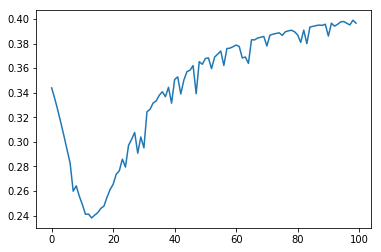

In [16]:
C4_start = time.time()
C4_W_out, C4_W_2, C4_W_1, C4_epochs, C4_losses = train(X_train,y_onehot, ## Ejemplos de entrenamiento y valores esperados
                                 W_1, W_2, W_out,    ## Pesos iniciales del entrenamiento
                                 sigmoid, d_sigmoid, ## Función de activación y su derivada
                                 cross_entropy, 100)
C4_end = time.time()
C4_time = C4_end - C4_start
print ("Tiempo  Entrenamiento caso 4: %s (seg) " % C4_time)
plt.plot(C4_epochs,C4_losses)

Matriz de confusión, para el Caso 2 -- (filas: valor real)(columnas:valor esperado)

In [17]:
from sklearn.metrics import confusion_matrix

y_predicted_C2 = decision_vec(forwardpass_vec(X_train, C2_W_1, C2_W_2, C2_W_out, sigmoid))

confusion_matrix(y_train, y_predicted_C2)


array([[ 0,  0, 50],
       [ 0,  0, 50],
       [ 0,  0, 50]])

# 2) Comparación con backpropagation de Keras

In [18]:
from keras.models import Sequential
from keras.layers.core import Dense
from keras.optimizers import SGD

### a) Modelo Keras para Caso 1

Tiempo Keras Entrenamiento Caso 1: 27.468942165374756 (seg) 


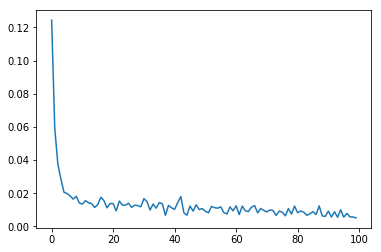

In [19]:
## Arquitectura de la red
modelC1 = Sequential()
modelC1.add(Dense(32, input_dim=X_train.shape[1], activation="relu"))
modelC1.add(Dense(16, activation="relu"))
modelC1.add(Dense(3, activation="softmax"))

#Configurar optimizador
modelC1.compile(optimizer=SGD(lr=0.1),loss="mse", metrics=["accuracy"])

#Entrenamiento
KC1_start = time.time()
historyC1 = modelC1.fit(X_train, y_onehot, epochs=100, batch_size=1, verbose=0)
KC1_end = time.time()
KC1_time = KC1_end - KC1_start
print ("Tiempo Keras Entrenamiento Caso 1: %s (seg) " % KC1_time)

#Gráfico
plt.plot(historyC1.history['loss'])

### b)  Modelo Keras para Caso 2

Tiempo Keras Entrenamiento Caso 2: 27.72850728034973 (seg) 


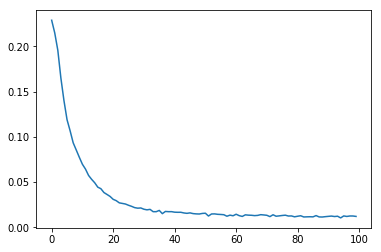

In [20]:

## Arquitectura de la red
modelC2 = Sequential()
modelC2.add(Dense(32, input_dim=X_train.shape[1], activation="sigmoid"))
modelC2.add(Dense(16, activation="sigmoid"))
modelC2.add(Dense(3, activation="softmax"))
#Configurar optimizador
modelC2.compile(optimizer=SGD(lr=0.1),loss="mse", metrics=["accuracy"])

#Entrenamiento
KC2_start = time.time()
historyC2 = modelC2.fit(X_train, y_onehot, epochs=100, batch_size=1, verbose=0)
KC2_end = time.time()
KC2_time = KC2_end - KC2_start
print ("Tiempo Keras Entrenamiento Caso 2: %s (seg) " % KC2_time)


#Gráfico
plt.plot(historyC2.history['loss'])

### c) Modelo Keras para Caso 3

Tiempo Keras Entrenamiento Caso 3: 31.428658962249756 (seg) 


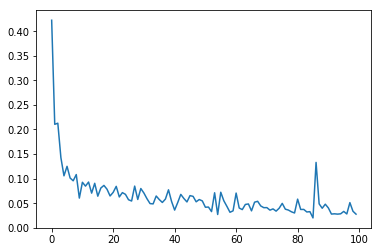

In [21]:
## Arquitectura de la red
modelC3 = Sequential()
modelC3.add(Dense(32, input_dim=X_train.shape[1], activation="relu"))
modelC3.add(Dense(16, activation="relu"))
modelC3.add(Dense(3, activation="softmax"))
#Configurar optimizador
modelC3.compile(optimizer=SGD(lr=0.1),loss="categorical_crossentropy", metrics=["accuracy"])

#Entrenamiento
KC3_start = time.time()
historyC3 = modelC3.fit(X_train, y_onehot, epochs=100, batch_size=1, verbose=0)
KC3_end = time.time()
KC3_time = KC3_end - KC3_start
print ("Tiempo Keras Entrenamiento Caso 3: %s (seg) " % KC3_time)



#Gráfico
plt.plot(historyC3.history['loss'])

### d) Modelo Keras para Caso 4

Tiempo Keras Entrenamiento Caso 4: 31.949390649795532 (seg) 


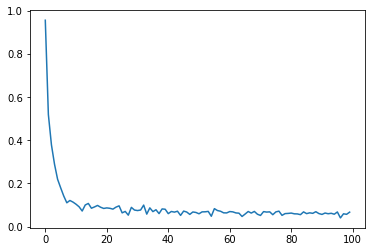

In [22]:
## Arquitectura de la red
modelC4 = Sequential()
modelC4.add(Dense(32, input_dim=X_train.shape[1], activation="sigmoid"))
modelC4.add(Dense(16, activation="sigmoid"))
modelC4.add(Dense(3, activation="softmax"))
#Configurar optimizador
modelC4.compile(optimizer=SGD(lr=0.1),loss="categorical_crossentropy", metrics=["accuracy"])

#Entrenamiento
KC4_start = time.time()
historyC4 = modelC4.fit(X_train, y_onehot, epochs=100, batch_size=1, verbose=0)
KC4_end = time.time()
KC4_time = KC4_end - KC4_start
print ("Tiempo Keras Entrenamiento Caso 4: %s (seg) " % KC4_time)



#Gráfico
plt.plot(historyC4.history['loss'])

## Comentarios sobre la convergencia

Respecto a la sección anterior (implementación tarea), sí existen diferencias en la convergencia con respecto 
a los resultados de Keras. Esto puede deberse a que el backpropagation
implementado en la tarea esta inestable, lo que podría estar provocando los resultados oscilantes que se ven en los 
gráficos. Otro factor es que a la implementación le faltan los sesgos, por lo que también podría etar afectando al
resultado.

En los resultados obtenidos de la implementación de Keras, se logra visualizar de forma clara la convergencia, 
disminuyendo el error a medida que aumentan las iteraciones.
Entre los casos 1 y 2, se observa menor oscilación cuando se utiliza la función sigmoid, siendo que todo el resto de
la configuración es similar. Sin embargo pareciera ser que con relu alcanza valores mínimos más rápido (20 a 30 epoch) mientrás que con sigmoid se alcanzan valores similares después de los 40 epochs.
Para los casos 3 y 4, también se observa menor oscilación cuando se utiliza la función sigmoid, sin embargo para el caso cuando se utiliza la función sigmoid, se llega en número menor de epochs a un mínimo, lo que es diferente al caso 1 y 2.

Con respecto al tiempo de ejecución, sí existe diferencia. La implementación de Keras tiene un tiempo mayor. Esto se puede deber a que la implementación desarrollada en la tarea realiza menos cálculos de operaciones.

# 4) Implementación momentum como variante

### Entrenamiento con momentum

In [23]:
def train_momentum(examples,expecteds, ## Ejemplos de entrenamiento y valores esperados
          W_1, W_2, W_out,    ## Pesos iniciales del entrenamiento
          actfunc, d_actfunc, ## Función de activación y su derivada
          lossfunc, num_epochs): ## Función de costo y número de epoch
    
    ##Tasa de aprendizaje
    LR = 0.1 
    ## Cantidad de ejemplos, considera el numero de filas del la matriz de entrada ejemplos
    nt = examples.shape[0] 
    
    ## Almacena el costo en cada epoch para ser usado en los gráficos
    loss_list = []
    
    ## Listas para almacenar los valores previos de V y de delta_W
    mu = 0.1
    ## Asumiendo que V(0) = 0
    listV_out       = [0]
    listV_2         = [0]
    listV_1         = [0]
    listDelta_W_out = []
    listDelta_W_2   = []
    listDelta_W_1   = []
    
    def computeV(i, Vs, DWs):
        return mu*Vs[i-1] - LR*DWs[i-1]        
    
    # indice para V
    iv = 0
    
    for epoch in range(num_epochs):
                
        i = random.randint(0,nt-1)
        x_example = np.asmatrix(examples[i]).T
        y_expected = expecteds[i]
        
        ## Se ejecuta el forward pass para el ejemplo seleccionado aleatoriamente.  Retorna el valor predecido
        ## y los valores de preactivación y activación
        y_predicted, (a_s, h_s)= forwardpass(x_example, W_1, W_2, W_out, actfunc)
        
        loss_list.append(lossfunc(y_expected, y_predicted))
        
        ## Ejecuta el backward pass para obtener los ajustes de los pesos
        delta_W_out, delta_W_2, delta_W_1 = backwardpass(x_example, y_predicted, y_expected, lossfunc, 
                 d_softmax, d_actfunc, d_actfunc,  
                 a_s[0], a_s[1], a_s[2],  
                 h_s[0], h_s[1], h_s[2],  
                 W_out, W_2, W_1)
        
        ### Actualizo historial de deltas
        listDelta_W_out.append(delta_W_out)
        listDelta_W_2.append(delta_W_2)
        listDelta_W_1.append(delta_W_1)

        iv = iv + 1
        listV_out.append(computeV(iv, listV_out, listDelta_W_out))
        listV_2.append(computeV(iv, listV_2, listDelta_W_2))
        listV_1.append(computeV(iv, listV_1, listDelta_W_1))        
        
        ##Ajustar los pesos
        W_1   = W_1   + listV_1[iv]
        W_2   = W_2   + listV_2[iv]
        W_out = W_out + listV_out[iv]
        
    return W_out, W_2, W_1, range(num_epochs),loss_list

### Comparando Casos 1, 2, 3 y 4 con entrenamiento con y sin momentum

Tiempo  Entrenamiento Momentum Caso 1: 0.05887317657470703 (seg) 


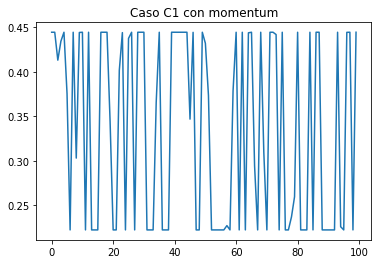

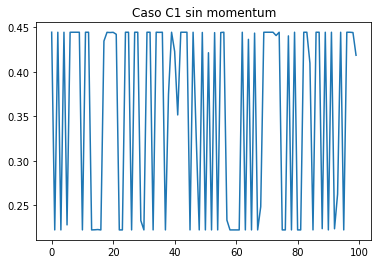

In [24]:
MC1_start = time.time()
MC1_W_out, MC1_W_2, MC1_W_1, MC1_epochs, MC1_losses = train_momentum(X_train,y_onehot,
                                 W_1, W_2, W_out,
                                 relu, d_relu,
                                 loss_mse, 100)
MC1_end = time.time()
MC1_time = MC1_end - MC1_start
print ("Tiempo  Entrenamiento Momentum Caso 1: %s (seg) " % MC1_time)
plt.title("Caso C1 con momentum")
plt.plot(MC1_epochs,MC1_losses)
plt.show()
plt.title("Caso C1 sin momentum")
plt.plot(C1_epochs,C1_losses)

Tiempo  Entrenamiento Momentum Caso 2: 0.053765058517456055 (seg) 


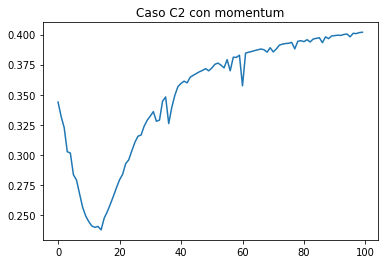

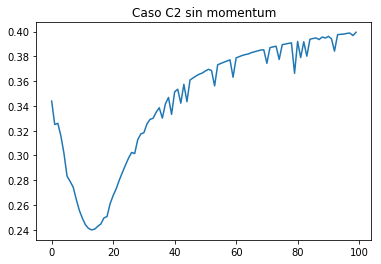

In [25]:
MC2_start = time.time()
MC2_W_out, MC2_W_2, MC2_W_1, MC2_epochs, MC2_losses = train_momentum(X_train,y_onehot,
                                 W_1, W_2, W_out,
                                 sigmoid, d_sigmoid,
                                 loss_mse, 100)
MC2_end = time.time()
MC2_time = MC2_end - MC2_start
print ("Tiempo  Entrenamiento Momentum Caso 2: %s (seg) " % MC2_time)
plt.title("Caso C2 con momentum")
plt.plot(MC2_epochs,MC2_losses)
plt.show()
plt.title("Caso C2 sin momentum")
plt.plot(C2_epochs,C2_losses)

Tiempo  Entrenamiento Momentum Caso 3: 0.17326998710632324 (seg) 


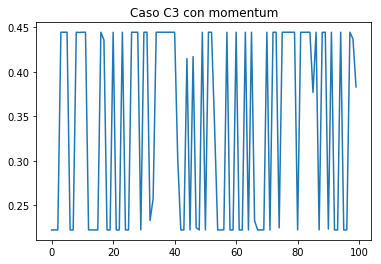

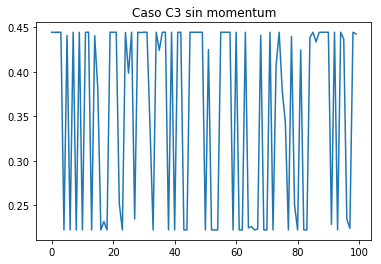

In [26]:
MC3_start = time.time()
MC3_W_out, MC3_W_2, MC3_W_1, MC3_epochs, MC3_losses = train_momentum(X_train,y_onehot,
                                 W_1, W_2, W_out,
                                 relu, d_relu,
                                 cross_entropy, 100)
MC3_end = time.time()
MC3_time = MC3_end - MC3_start
print ("Tiempo  Entrenamiento Momentum Caso 3: %s (seg) " % MC3_time)
plt.title("Caso C3 con momentum")
plt.plot(MC3_epochs,MC3_losses)
plt.show()
plt.title("Caso C3 sin momentum")
plt.plot(C3_epochs,C3_losses)

Tiempo  Entrenamiento Momentum Caso 4: 0.05130791664123535 (seg) 


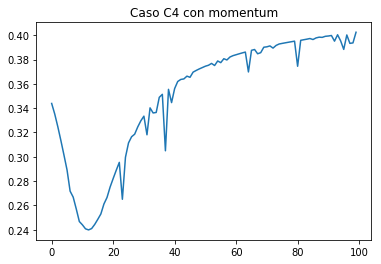

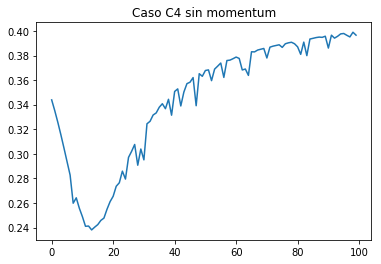

In [27]:
MC4_start = time.time()
MC4_W_out, MC4_W_2, MC4_W_1, MC4_epochs, MC4_losses = train_momentum(X_train,y_onehot,
                                 W_1, W_2, W_out,
                                 sigmoid, d_sigmoid,
                                 cross_entropy, 100)
MC4_end = time.time()
MC4_time = MC4_end - MC4_start
print ("Tiempo  Entrenamiento Momentum Caso 4: %s (seg) " % MC4_time)
plt.title("Caso C4 con momentum")
plt.plot(MC3_epochs,MC4_losses)
plt.show()
plt.title("Caso C4 sin momentum")
plt.plot(C4_epochs,C4_losses)

### Comentarios sobre el uso de momentum

No se aprecia diferencia entre el entrenamiento con momentum y el entrenamiento clásico. Esto se debe principalmente a los problemas en la estabilidad de backwardpass.